In [1]:
# Import aller benötigten Programmbibliotheken

import pandas as pd
import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import random
import implicit
import nmslib
import annoy
from implicit.evaluation import precision_at_k, mean_average_precision_at_k
import matplotlib
import matplotlib.pyplot as plt

# Import des Online Retail-Datensatzes

OnlineRetail = pd.read_excel(r"C:\Users\patri\Google Drive\Uni!\Master WiInfo\IV. Semester\Seminararbeit\Datensätze\Online Retail\Online Retail.xlsx")

# Anzeigen des 'Datensatzkopfes'

OnlineRetail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [2]:
# Der Datensatz enhält insgesamt 541909 Zeilen

OnlineRetail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [3]:
# Zeilen, die keine CustomerID enthalten, entfernen. 
# Ohne CustomerID kann später in der Matrix keine Zuordnung zu einem Produkt erfolgen. 

CleanedData = OnlineRetail.loc[pd.isnull(OnlineRetail.CustomerID) == False]

In [4]:
# Nach dem Entfernen der Zeilen ohne CustomerID enthält der Datensatz noch 406829 Zeilen

CleanedData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      406829 non-null object
StockCode      406829 non-null object
Description    406829 non-null object
Quantity       406829 non-null int64
InvoiceDate    406829 non-null datetime64[ns]
UnitPrice      406829 non-null float64
CustomerID     406829 non-null float64
Country        406829 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [5]:
#Erstellen einer separaten Tabelle, die nur den StockCode und die eine Description der Artikel enthält

ItemData = CleanedData[["StockCode", "Description"]].drop_duplicates()

# Formatieren der Spalte "StockCode" von einem numerischen Wert in einen String

ItemData["StockCode"] = ItemData["StockCode"].astype(str)

In [6]:
# Die separate Tabelle 'ItemData' enthält die 3916 Produkte des Unternehmens
 
ItemData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3916 entries, 0 to 540421
Data columns (total 2 columns):
StockCode      3916 non-null object
Description    3916 non-null object
dtypes: object(2)
memory usage: 91.8+ KB


In [7]:
# Anzeigen des 'Tabellenkopfes'

ItemData.head()

,StockCode,Description
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER
1,71053,WHITE METAL LANTERN
2,84406B,CREAM CUPID HEARTS COAT HANGER
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE
4,84029E,RED WOOLLY HOTTIE WHITE HEART.


In [8]:
# Der Datensatz enthält nicht nur Verkäufe, sondern auch Rückgaben, da negative Mengen in der Spalte 'Quantity' vorhanden sind.

CleanedData["Quantity"].describe()

count    406829.000000
mean         12.061303
std         248.693370
min      -80995.000000
25%           2.000000
50%           5.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

In [9]:
# Überführen der CustomerID in numerischen Wert (int)
CleanedData["CustomerID"] = CleanedData["CustomerID"].astype(int)
CleanedData.info()

C:\Users\patri\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      406829 non-null object
StockCode      406829 non-null object
Description    406829 non-null object
Quantity       406829 non-null int64
InvoiceDate    406829 non-null datetime64[ns]
UnitPrice      406829 non-null float64
CustomerID     406829 non-null int32
Country        406829 non-null object
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(4)
memory usage: 26.4+ MB


In [10]:
# Reduzieren des Online Retail Datensatzes auf die benötigten Daten für die Kunden-Produkt-Matrix:

CleanedData = CleanedData[["StockCode", "Quantity", "CustomerID"]]

# Gruppieren und aufsummieren der Daten, um Rückgaben und Käufe 'auszugleichen':

GroupedData = CleanedData.groupby(["CustomerID", "StockCode"]).sum().reset_index()

# Sollten durch das Aufsummieren von Rückgaben und Käufen 0-Werte entstanden sein, werden diese nun durch 1 ersetzt.
# Dies gibt weiterhin ein Kaufinteresse des Kunden an diesem Artikel wieder.

GroupedData["Quantity"].loc[GroupedData["Quantity"] == 0] = 1

# Anzeigen des 'Tabellenkopfes' des reduzierten Datensatzes

GroupedData.head()

C:\Users\patri\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,CustomerID,StockCode,Quantity
0,12346,23166,1
1,12347,16008,24
2,12347,17021,36
3,12347,20665,6
4,12347,20719,40


In [11]:
# Es sind weiterhin mehrere Werte, die kleiner 0 sind,im Datensatz vorhanden d.h. im betrachteten Zeitraum wurden mehr Produkte zurückgegeben als gekauft wurden.

GroupedData["Quantity"].describe()

count    267615.000000
mean         18.341240
std          97.388138
min       -9360.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       12540.000000
Name: Quantity, dtype: float64

In [12]:
# Mengen, die weiterhin kleiner 0 sind, werden herausgefiltert (d.h. mehr Rückgaben als Verkäufe).
# Dies wird getan, da sich diese negativen Mengen nicht korrekt gegenüber früheren Bestelleungen gegengerechnen lassen.

PurchasedData = GroupedData[GroupedData["Quantity"] > 0]
PurchasedData.head()

,CustomerID,StockCode,Quantity
0,12346,23166,1
1,12347,16008,24
2,12347,17021,36
3,12347,20665,6
4,12347,20719,40


In [13]:
# Erstellen einer Liste von Kunden aus dem DataFrame 'PurchasedData'

Customers = list(np.sort(PurchasedData["CustomerID"].unique()))

# Erstellen einer Liste von Produkten aus dem DataFrame 'PurchasedData'

Products = list(PurchasedData["StockCode"].unique())

# Erstellen einer Liste von Mengen aus dem DataFrame 'PurchasedData'

Quantities = list(PurchasedData["Quantity"])

In [14]:
# Implicit benötigt eine Sparse Matrix der Form Produkt / Kunde / Bewertung

# Erstellen der Spalten der Matrix

cols = PurchasedData["CustomerID"].astype("category", categories = Customers).cat.codes

# Erstellen der Reihen der Matrix

rows = PurchasedData["StockCode"].astype("category", categories = Products).cat.codes

# Erstellen der Matrix

PurchaseMatrix = sparse.csr_matrix((Quantities, (rows, cols)), shape = (len(Products), len(Customers)))

C:\Users\patri\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  exec(code_obj, self.user_global_ns, self.user_ns)


In [15]:
# Anzeigen der Matrix

PurchaseMatrix

<3664x4338 sparse matrix of type '<class 'numpy.int32'>'
	with 266723 stored elements in Compressed Sparse Row format>

In [16]:
# Berechnung der 'Sparsity' der Matrix
# Mit einer Sparsity von 98,32 % ist die Matrix ausreichend befüllt, um aussagelräftige Empfehlungen generieren zu können. 

MatrixSize = PurchaseMatrix.shape[0]*PurchaseMatrix.shape[1]
NumberPurchases = len(PurchaseMatrix.nonzero()[0])
Sparsity = 100*(1 - (NumberPurchases/MatrixSize))
Sparsity

98.32190920694744

In [17]:
# Für das Training und die spätere Bewertung der Algorithmen wird der Datensatz in Trainings- & Testdaten unterteilt.
# 80 % der Daten werden für das Training der Algorithmen verwendet.

def train(ratings, pct_test = 0.2):
    test_set = ratings.copy()
    test_set[test_set != 0] = 1
    training_set = ratings.copy()
    nonzero_inds = training_set.nonzero()
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1]))
    random.seed(0)
    num_samples = int(np.ceil(pct_test * len(nonzero_pairs)))
    samples = random.sample(nonzero_pairs, num_samples)
    user_inds = [index[0] for index in samples]
    item_inds = [index[1] for index in samples]
    training_set[user_inds, item_inds] = 0
    training_set.eliminate_zeros()
    return training_set, test_set, list(set(user_inds))

ProductTrain, ProductTest, ProductUsersAltered = train(PurchaseMatrix, pct_test = 0.2)

In [18]:
# Anzeigend er Trainings-Matrix

ProductTrain

<3664x4338 sparse matrix of type '<class 'numpy.int32'>'
	with 213378 stored elements in Compressed Sparse Row format>

In [19]:
# Anzeigen der Trainings-Matrix

ProductTest

<3664x4338 sparse matrix of type '<class 'numpy.int32'>'
	with 266723 stored elements in Compressed Sparse Row format>

In [60]:
# Erstellen von Listen für die Auswertung der Algorithmen

x = []
for n in range(0, 200):
    x.append(n)

x2 = []
for m in range(0, 250):
    x2.append(m)
  
x3 = []
for k in np.arange (0, 1, 0.005):
    x3.append(k)

x4 = []
for l in np.arange (0, 1.25, 0.005):
    x4.append(l)
    
x5 = []
for o in range(0, 400):
    x5.append(o)
    
x6 = []
for p in range(-100, 100):
    x6.append(p)

In [21]:
# Berechnung der optimalen Zahl an Iterationen für den ALS-Algorithmus

I_ALS = []
for i in range (0,200):
    ALS = implicit.als.AlternatingLeastSquares(iterations = i)
    ALS.fit(ProductTrain)
    P_ALS = precision_at_k(ALS, ProductTrain.T.tocsr(), ProductTest.T.tocsr(), K=10, num_threads=4)
    I_ALS.append(P_ALS)
    
MINI_ALS = I_ALS[0]
MAXI_ALS = I_ALS[0]

for Zahl in I_ALS:
  if Zahl < MINI_ALS:
    MINI_ALS = Zahl
  elif Zahl > MAXI_ALS:
    MAXI_ALS = Zahl
print("max:",MAXI_ALS)
print("min:",MINI_ALS)

I_ALS.index(MAXI_ALS)

0it [00:00, ?it/s]
100%|██████████| 4338/4338 [00:01<00:00, 2294.09it/s]
100%|██████████| 1.0/1 [00:00<00:00, 10.55it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1917.55it/s]
100%|██████████| 2.0/2 [00:00<00:00, 12.66it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1833.80it/s]
100%|██████████| 3.0/3 [00:00<00:00, 13.70it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1790.32it/s]
100%|██████████| 4.0/4 [00:00<00:00, 14.03it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1752.74it/s]
100%|██████████| 5.0/5 [00:00<00:00, 14.11it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1787.45it/s]
100%|██████████| 6.0/6 [00:00<00:00, 13.95it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1767.05it/s]
100%|██████████| 7.0/7 [00:00<00:00, 13.57it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1633.93it/s]
100%|██████████| 8.0/8 [00:00<00:00, 13.72it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1758.46it/s]
100%|██████████| 9.0/9 [00:00<00:00, 14.11it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1701.88it/s]
100%|████

100%|██████████| 4338/4338 [00:02<00:00, 1519.40it/s]
100%|██████████| 78.0/78 [00:06<00:00, 11.47it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1599.24it/s]
100%|██████████| 79.0/79 [00:06<00:00, 12.72it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1584.42it/s]
100%|██████████| 80.0/80 [00:06<00:00, 11.87it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1578.04it/s]
100%|██████████| 81.0/81 [00:06<00:00, 12.26it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1582.68it/s]
100%|██████████| 82.0/82 [00:06<00:00, 12.41it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1582.07it/s]
100%|██████████| 83.0/83 [00:06<00:00, 12.04it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1594.33it/s]
100%|██████████| 84.0/84 [00:06<00:00, 12.42it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1576.95it/s]
100%|██████████| 85.0/85 [00:06<00:00, 12.30it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1472.52it/s]
100%|██████████| 86.0/86 [00:07<00:00, 11.62it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1541.14it/s]
100%|█████

100%|██████████| 155.0/155 [00:12<00:00, 12.40it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1587.85it/s]
100%|██████████| 156.0/156 [00:12<00:00, 10.82it/s]
100%|██████████| 4338/4338 [00:03<00:00, 1431.74it/s]
100%|██████████| 157.0/157 [00:12<00:00, 12.24it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1552.32it/s]
100%|██████████| 158.0/158 [00:12<00:00, 12.48it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1602.55it/s]
100%|██████████| 159.0/159 [00:12<00:00, 12.38it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1538.28it/s]
100%|██████████| 160.0/160 [00:13<00:00, 11.95it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1533.38it/s]
100%|██████████| 161.0/161 [00:13<00:00, 11.56it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1438.99it/s]
100%|██████████| 162.0/162 [00:13<00:00, 12.06it/s]
100%|██████████| 4338/4338 [00:03<00:00, 1355.22it/s]
100%|██████████| 163.0/163 [00:17<00:00,  9.47it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1477.28it/s]
100%|██████████| 164.0/164 [00:13<00:00, 11.73

max: 0.14573400874056416
min: 0.004419944378228049


84

In [22]:
# Berechnung der optimalen Zahl an Factors für den ALS-Algorithmus

F_ALS = []
for f in range (0, 250):
    ALS = implicit.als.AlternatingLeastSquares(factors = f)
    ALS.fit(ProductTrain)
    P_ALS = precision_at_k(ALS, ProductTrain.T.tocsr(), ProductTest.T.tocsr(), K=10, num_threads=4)
    F_ALS.append(P_ALS)
    
MINF_ALS = F_ALS[0]
MAXF_ALS = F_ALS[0]

for Zahl in F_ALS:
  if Zahl < MINF_ALS:
    MINF_ALS = Zahl
  elif Zahl > MAXF_ALS:
    MAXF_ALS = Zahl
print("max:",MAXF_ALS)
print("min:",MINF_ALS)

F_ALS.index(MAXF_ALS)

100%|██████████| 15.0/15 [00:03<00:00,  4.61it/s]
100%|██████████| 4338/4338 [00:00<00:00, 4389.84it/s]
100%|██████████| 15.0/15 [00:00<00:00, 24.22it/s]
100%|██████████| 4338/4338 [00:00<00:00, 4434.37it/s]
100%|██████████| 15.0/15 [00:00<00:00, 18.43it/s]
100%|██████████| 4338/4338 [00:01<00:00, 4063.38it/s]
100%|██████████| 15.0/15 [00:00<00:00, 17.62it/s]
100%|██████████| 4338/4338 [00:01<00:00, 3711.42it/s]
100%|██████████| 15.0/15 [00:00<00:00, 16.66it/s]
100%|██████████| 4338/4338 [00:01<00:00, 3728.95it/s]
100%|██████████| 15.0/15 [00:00<00:00, 18.29it/s]
100%|██████████| 4338/4338 [00:02<00:00, 2015.79it/s]
100%|██████████| 15.0/15 [00:00<00:00, 17.12it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1990.29it/s]
100%|██████████| 15.0/15 [00:00<00:00, 15.96it/s]
100%|█████████▉| 4336/4338 [00:02<00:00, 1935.27it/s]
100%|██████████| 15.0/15 [00:00<00:00, 17.57it/s]
100%|██████████| 4338/4338 [00:02<00:00, 2002.74it/s]
100%|██████████| 15.0/15 [00:00<00:00, 16.63it/s]
100%|█████████

100%|██████████| 4338/4338 [00:02<00:00, 1628.37it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.37it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1597.79it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.55it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1628.39it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.94it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1615.04it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.52it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1579.74it/s]
100%|██████████| 15.0/15 [00:01<00:00, 11.76it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1618.06it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.44it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1597.20it/s]
100%|██████████| 15.0/15 [00:01<00:00, 11.44it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1564.39it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.29it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1672.99it/s]
100%|██████████| 15.0/15 [00:01<00:00, 13.03it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1662.69it/s]
100%|█████

100%|██████████| 15.0/15 [00:01<00:00,  9.58it/s]
100%|██████████| 4338/4338 [00:03<00:00, 1390.91it/s]
100%|██████████| 15.0/15 [00:01<00:00,  9.33it/s]
100%|██████████| 4338/4338 [00:03<00:00, 1409.54it/s]
100%|██████████| 15.0/15 [00:01<00:00,  8.64it/s]
100%|██████████| 4338/4338 [00:03<00:00, 1362.37it/s]
100%|██████████| 15.0/15 [00:01<00:00,  9.27it/s]
100%|██████████| 4338/4338 [00:03<00:00, 1365.50it/s]
100%|██████████| 15.0/15 [00:01<00:00,  9.34it/s]
100%|██████████| 4338/4338 [00:03<00:00, 1400.77it/s]
100%|██████████| 15.0/15 [00:01<00:00,  9.30it/s]
100%|██████████| 4338/4338 [00:03<00:00, 1380.53it/s]
100%|██████████| 15.0/15 [00:01<00:00,  9.50it/s]
100%|██████████| 4338/4338 [00:03<00:00, 1397.40it/s]
100%|██████████| 15.0/15 [00:01<00:00,  9.32it/s]
100%|██████████| 4338/4338 [00:03<00:00, 1392.02it/s]
100%|██████████| 15.0/15 [00:01<00:00,  8.36it/s]
100%|█████████▉| 4334/4338 [00:03<00:00, 1340.34it/s]
100%|██████████| 15.0/15 [00:01<00:00,  8.67it/s]
100%|█████████

100%|██████████| 4338/4338 [00:03<00:00, 1236.02it/s]
100%|██████████| 15.0/15 [00:02<00:00,  6.70it/s]
100%|██████████| 4338/4338 [00:03<00:00, 1249.08it/s]
100%|██████████| 15.0/15 [00:02<00:00,  7.07it/s]
100%|██████████| 4338/4338 [00:03<00:00, 1306.55it/s]
100%|██████████| 15.0/15 [00:02<00:00,  6.98it/s]
100%|██████████| 4338/4338 [00:03<00:00, 1243.67it/s]
100%|██████████| 15.0/15 [00:02<00:00,  6.73it/s]
100%|██████████| 4338/4338 [00:03<00:00, 1255.21it/s]
100%|██████████| 15.0/15 [00:02<00:00,  7.10it/s]
100%|██████████| 4338/4338 [00:03<00:00, 1260.34it/s]
100%|██████████| 15.0/15 [00:02<00:00,  6.43it/s]
100%|██████████| 4338/4338 [00:03<00:00, 1220.64it/s]
100%|██████████| 15.0/15 [00:02<00:00,  6.75it/s]
100%|██████████| 4338/4338 [00:03<00:00, 1249.78it/s]
100%|██████████| 15.0/15 [00:02<00:00,  5.78it/s]
100%|██████████| 4338/4338 [00:03<00:00, 1236.29it/s]
100%|██████████| 15.0/15 [00:02<00:00,  6.11it/s]
100%|██████████| 4338/4338 [00:04<00:00, 1036.87it/s]
100%|█████

max: 0.15432558601509733
min: 0.0059843067143424715


243

In [23]:
# Berechnung der optimalen Zahl an Regularization für den ALS-Algorithmus

R_ALS= []
for r in np.arange (0, 1.25, 0.005):
    ALS = implicit.als.AlternatingLeastSquares(regularization = r)
    ALS.fit(ProductTrain)
    P_ALS = precision_at_k(ALS, ProductTrain.T.tocsr(), ProductTest.T.tocsr(), K=10, num_threads=4)
    R_ALS.append(P_ALS)
    
MINR_ALS = R_ALS[0]
MAXR_ALS = R_ALS[0]

for Zahl in R_ALS:
  if Zahl < MINR_ALS:
    MINR_ALS = Zahl
  elif Zahl > MAXR_ALS:
    MAXR_ALS = Zahl
print("max:",MAXR_ALS)
print("min:",MINR_ALS)

x4[R_ALS.index(MAXR_ALS)]

100%|██████████| 15.0/15 [00:01<00:00, 12.64it/s]
100%|██████████| 4338/4338 [00:03<00:00, 1437.61it/s]
100%|██████████| 15.0/15 [00:01<00:00,  9.47it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1471.51it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.31it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1497.92it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.45it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1558.76it/s]
100%|██████████| 15.0/15 [00:01<00:00, 11.86it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1467.09it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.04it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1506.76it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.12it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1454.29it/s]
100%|██████████| 15.0/15 [00:01<00:00, 11.60it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1492.29it/s]
100%|██████████| 15.0/15 [00:01<00:00, 11.39it/s]
100%|██████████| 4338/4338 [00:03<00:00, 1271.38it/s]
100%|██████████| 15.0/15 [00:01<00:00, 10.47it/s]
100%|█████████

100%|██████████| 4338/4338 [00:03<00:00, 1385.10it/s]
100%|██████████| 15.0/15 [00:01<00:00,  8.98it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1462.59it/s]
100%|██████████| 15.0/15 [00:01<00:00, 11.05it/s]
100%|██████████| 4338/4338 [00:03<00:00, 1430.23it/s]
100%|██████████| 15.0/15 [00:01<00:00, 11.78it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1447.45it/s]
100%|██████████| 15.0/15 [00:01<00:00, 11.60it/s]
100%|██████████| 4338/4338 [00:03<00:00, 1426.95it/s]
100%|██████████| 15.0/15 [00:01<00:00, 11.73it/s]
100%|██████████| 4338/4338 [00:03<00:00, 1384.18it/s]
100%|██████████| 15.0/15 [00:01<00:00, 10.78it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1532.88it/s]
100%|██████████| 15.0/15 [00:01<00:00, 10.84it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1513.09it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.53it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1491.49it/s]
100%|██████████| 15.0/15 [00:01<00:00, 11.82it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1468.58it/s]
100%|█████

100%|██████████| 15.0/15 [00:01<00:00, 12.83it/s]
100%|██████████| 4338/4338 [00:03<00:00, 1432.16it/s]
100%|██████████| 15.0/15 [00:01<00:00, 11.29it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1493.34it/s]
100%|██████████| 15.0/15 [00:01<00:00, 11.81it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1507.86it/s]
100%|██████████| 15.0/15 [00:01<00:00, 11.44it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1513.09it/s]
100%|██████████| 15.0/15 [00:01<00:00, 11.28it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1475.10it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.15it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1542.76it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.42it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1509.95it/s]
100%|██████████| 15.0/15 [00:01<00:00, 11.98it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1553.78it/s]
100%|██████████| 15.0/15 [00:01<00:00, 11.16it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1553.83it/s]
100%|██████████| 15.0/15 [00:01<00:00, 11.90it/s]
100%|█████████

100%|██████████| 4338/4338 [00:03<00:00, 1317.77it/s]
100%|██████████| 15.0/15 [00:01<00:00, 11.35it/s]
100%|██████████| 4338/4338 [00:03<00:00, 1438.10it/s]
100%|██████████| 15.0/15 [00:01<00:00, 10.82it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1560.11it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.24it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1518.97it/s]
100%|██████████| 15.0/15 [00:01<00:00, 11.81it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1520.02it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.09it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1515.80it/s]
100%|██████████| 15.0/15 [00:01<00:00, 11.42it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1454.26it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.07it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1536.71it/s]
100%|██████████| 15.0/15 [00:01<00:00, 11.23it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1506.82it/s]
100%|██████████| 15.0/15 [00:01<00:00, 11.27it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1504.18it/s]
100%|█████

max: 0.1436978545887962
min: 0.13806118394914582


0.68

In [24]:
# Precision ALS-Standard

ALS = implicit.als.AlternatingLeastSquares()
ALS.fit(ProductTrain)
P_ALS = precision_at_k(ALS, ProductTrain.T.tocsr(), ProductTest.T.tocsr(), K=10, num_threads=4)
P_ALS

100%|██████████| 15.0/15 [00:01<00:00, 12.07it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1494.30it/s]


0.14141338895510527

In [25]:
# Precision ALS-Optimiert

ALS = implicit.als.AlternatingLeastSquares(iterations = I_ALS.index(MAXI_ALS), factors = F_ALS.index(MAXF_ALS), regularization = x4[R_ALS.index(MAXR_ALS)])
ALS.fit(ProductTrain)
P_ALS_OPT = precision_at_k(ALS, ProductTrain.T.tocsr(), ProductTest.T.tocsr(), K=10, num_threads=4)
P_ALS_OPT

100%|██████████| 84.0/84 [00:13<00:00,  6.55it/s]
100%|██████████| 4338/4338 [00:03<00:00, 1221.97it/s]


0.15529400079459674

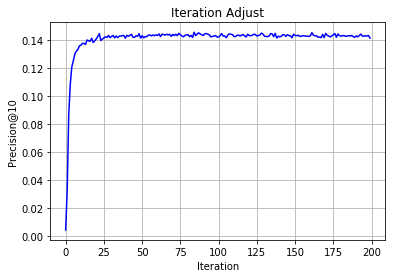

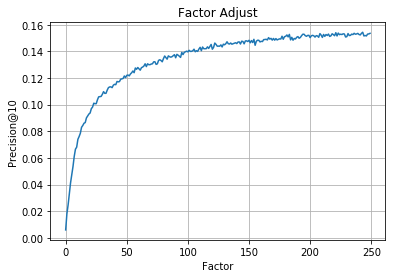

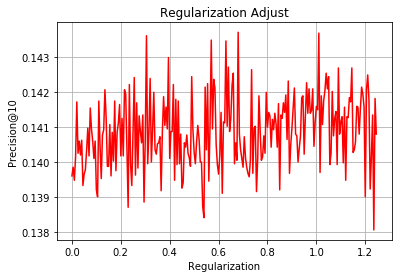

In [26]:
# Plotten der einzelnen Paramter-Precision-Werte für den ALS-Algorithmus

fig, it = plt.subplots()
it.plot(x, I_ALS, 'b')

it.set(xlabel='Iteration', ylabel='Precision@10', title='Iteration Adjust')
it.grid()

plt.show()

fig, fa = plt.subplots()
fa.plot(x2, F_ALS)

fa.set(xlabel='Factor', ylabel='Precision@10', title='Factor Adjust')
fa.grid()

plt.show()

fig, re = plt.subplots()
re.plot(x4, R_ALS, 'r')

re.set(xlabel='Regularization', ylabel='Precision@10', title='Regularization Adjust')
re.grid()

plt.show()

In [27]:
# Berechnung der optimalen Zahl an Iterationen für den BPR-Algorithmus

I_BPR = []
for i in range (0,200):
    BPR = implicit.bpr.BayesianPersonalizedRanking(iterations = i)
    BPR.fit(ProductTrain)
    P_BPR = precision_at_k(BPR, ProductTrain.T.tocsr(), ProductTest.T.tocsr(), K=10, num_threads=4)
    I_BPR.append(P_BPR)
    
MINI_BPR = I_BPR[0]
MAXI_BPR = I_BPR[0]

for Zahl in I_BPR:
  if Zahl < MINI_BPR:
    MINI_BPR = Zahl
  elif Zahl > MAXI_BPR:
    MAXI_BPR = Zahl
print("max:",MAXI_BPR)
print("min:",MINI_BPR)

I_BPR.index(MAXI_BPR)

0it [00:00, ?it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1881.32it/s]


100%|██████████| 4338/4338 [00:02<00:00, 1671.64it/s]


100%|██████████| 183/183 [00:08<00:00, 17.16it/s, correct=97.47%, skipped=8.91%]


100%|██████████| 4338/4338 [00:02<00:00, 1687.20it/s]


max: 0.10595450933651172
min: 0.0035260230433055225


78

In [28]:
# Berechnung der optimalen Zahl an Factors für den BPR-Algorithmus

F_BPR = []
for f in range (0, 250):
    BPR = implicit.bpr.BayesianPersonalizedRanking(factors = f)
    BPR.fit(ProductTrain)
    P_BPR = precision_at_k(BPR, ProductTrain.T.tocsr(), ProductTest.T.tocsr(), K=10, num_threads=4)
    F_BPR.append(P_BPR)
    
MINF_BPR = F_BPR[0]
MAXF_BPR = F_BPR[0]

for Zahl in F_BPR:
  if Zahl < MINF_BPR:
    MINF_BPR = Zahl
  elif Zahl > MAXF_BPR:
    MAXF_BPR = Zahl
print("max:",MAXF_BPR)
print("min:",MINF_BPR)

F_BPR.index(MAXF_BPR)

C:\Users\patri\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
100%|██████████| 100/100 [00:03<00:00, 29.02it/s, correct=92.29%, skipped=8.92%]


100%|██████████| 4338/4338 [00:02<00:00, 1611.56it/s]


100%|██████████| 100/100 [00:07<00:00, 13.92it/s, correct=92.76%, skipped=8.95%]


100%|██████████| 4338/4338 [00:02<00:00, 1710.55it/s]


100%|██████████| 4338/4338 [00:02<00:00, 1600.91it/s]


max: 0.10461362733412793
min: 0.0059843067143424715


191

In [29]:
# Berechnung der optimalen Zahl an Regularization für den BPR-Algorithmus

R_BPR= []
for r in np.arange (0, 1.25, 0.005):
    BPR = implicit.bpr.BayesianPersonalizedRanking(regularization = r)
    BPR.fit(ProductTrain)
    P_BPR = precision_at_k(BPR, ProductTrain.T.tocsr(), ProductTest.T.tocsr(), K=10, num_threads=4)
    R_BPR.append(P_BPR)
    
MINR_BPR = R_BPR[0]
MAXR_BPR = R_BPR[0]

for Zahl in R_BPR:
  if Zahl < MINR_BPR:
    MINR_BPR = Zahl
  elif Zahl > MAXR_BPR:
    MAXR_BPR = Zahl
    
print("max:",MAXR_BPR)
print("min:",MINR_BPR)

x4[R_BPR.index(MAXR_BPR)]

100%|██████████| 100/100 [00:04<00:00, 20.43it/s, correct=51.22%, skipped=8.92%]


100%|██████████| 4338/4338 [00:02<00:00, 2021.47it/s]


100%|██████████| 100/100 [00:04<00:00, 22.64it/s, correct=50.75%, skipped=8.93%]


100%|██████████| 4338/4338 [00:02<00:00, 1899.16it/s]


100%|██████████| 4338/4338 [00:02<00:00, 1917.77it/s]


max: 0.10540822407628128
min: 0.004568931267381803


0.0

In [30]:
# Berechnung der optimalen Zahl an Learning Rate für den BPR-Algorithmus

LR_BPR= []
for lr in np.arange (0, 1, 0.005):
    BPR = implicit.bpr.BayesianPersonalizedRanking(learning_rate = lr)
    BPR.fit(ProductTrain)
    P_BPR = precision_at_k(BPR, ProductTrain.T.tocsr(), ProductTest.T.tocsr(), K=10, num_threads=4)
    LR_BPR.append(P_BPR)
    
MINLR_BPR = LR_BPR[0]
MAXLR_BPR = LR_BPR[0]

for Zahl in LR_BPR:
  if Zahl < MINLR_BPR:
    MINLR_BPR = Zahl
  elif Zahl > MAXLR_BPR:
    MAXLR_BPR = Zahl
    
print("max:",MAXLR_BPR)
print("min:",MINLR_BPR)

x3[LR_BPR.index(MAXLR_BPR)]

100%|██████████| 100/100 [00:05<00:00, 18.59it/s, correct=0.00%, skipped=8.99%]


100%|██████████| 100/100 [00:04<00:00, 20.35it/s, correct=0.00%, skipped=8.96%]


100%|██████████| 100/100 [00:04<00:00, 22.88it/s, correct=0.00%, skipped=8.91%]


100%|██████████| 4338/4338 [00:02<00:00, 2130.57it/s]


max: 0.10232916170043703
min: 0.002582439411998411


0.01

In [31]:
# Precision BPR-Standard

BPR = implicit.bpr.BayesianPersonalizedRanking()
BPR.fit(ProductTrain)
P_ALS = precision_at_k(BPR, ProductTrain.T.tocsr(), ProductTest.T.tocsr(), K=10, num_threads=4)
P_ALS

100%|██████████| 4338/4338 [00:02<00:00, 1746.28it/s]


0.10168355184743742

In [32]:
# Precision BPR-Optimiert

BPR = implicit.bpr.BayesianPersonalizedRanking(iterations = I_BPR.index(MAXI_BPR), factors = F_BPR.index(MAXF_BPR), regularization = x4[R_BPR.index(MAXR_BPR)], learning_rate = x3[LR_BPR.index(MAXLR_BPR)])
BPR.fit(ProductTrain)
P_BPR_OPT = precision_at_k(BPR, ProductTrain.T.tocsr(), ProductTest.T.tocsr(), K=10, num_threads=4)
P_BPR_OPT

100%|██████████| 4338/4338 [00:02<00:00, 1691.31it/s]


0.11298172427493047

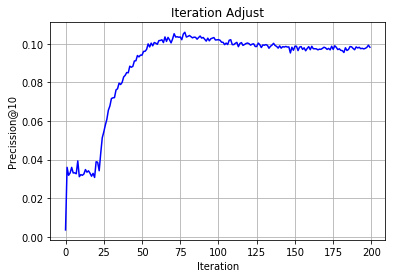

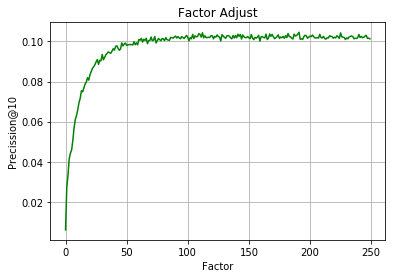

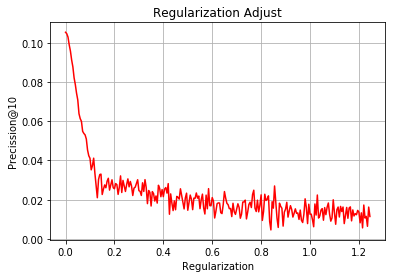

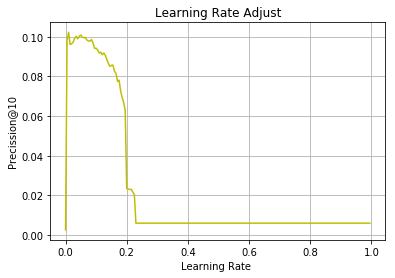

In [33]:
# Plotten der einzelnen Paramter-Precision-Werte für den BPR-Algorithmus

fig, it = plt.subplots()
it.plot(x, I_BPR, 'b')

it.set(xlabel='Iteration', ylabel='Precission@10', title='Iteration Adjust')
it.grid()

plt.show()

fig, fa = plt.subplots()
fa.plot(x2, F_BPR, 'g')

fa.set(xlabel='Factor', ylabel='Precission@10', title='Factor Adjust')
fa.grid()

plt.show()

fig, re = plt.subplots()
re.plot(x4, R_BPR, 'r')

re.set(xlabel='Regularization', ylabel='Precission@10', title='Regularization Adjust')
re.grid()

plt.show()

fig, lr= plt.subplots()
lr.plot(x3, LR_BPR, 'y')

lr.set(xlabel='Learning Rate ', ylabel='Precission@10', title='Learning Rate Adjust')
lr.grid()

plt.show()

In [55]:
# Berechnung der optimalen Zahl an "Bäumen" für den BPR-Algorithmus

NT_AN_ALS = []
for i in range (0,400):
    AN_ALS = implicit.approximate_als.AnnoyAlternatingLeastSquares(n_trees = i)
    AN_ALS.fit(ProductTrain)
    P_AN_ALS = precision_at_k(AN_ALS, ProductTrain.T.tocsr(), ProductTest.T.tocsr(), K=10, num_threads=4)
    NT_AN_ALS.append(P_AN_ALS)
    
MINI_NT_AN_ALS = NT_AN_ALS[0]
MAXI_NT_AN_ALS = NT_AN_ALS[0]

for Zahl in NT_AN_ALS:
  if Zahl < MINI_NT_AN_ALS:
    MINI_NT_AN_ALS = Zahl
  elif Zahl > MAXI_NT_AN_ALS:
    MAXI_NT_AN_ALS = Zahl
    
print("max:", MAXI_NT_AN_ALS)
print("min:", MINI_NT_AN_ALS)

NT = NT_AN_ALS.index(MAXI_NT_AN_ALS)
NT

100%|██████████| 15.0/15 [00:01<00:00, 11.49it/s]
100%|██████████| 4338/4338 [00:00<00:00, 5861.98it/s]
100%|██████████| 15.0/15 [00:01<00:00, 10.38it/s]
100%|██████████| 4338/4338 [00:00<00:00, 5184.26it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.99it/s]
100%|██████████| 4338/4338 [00:01<00:00, 4264.31it/s]
100%|██████████| 15.0/15 [00:01<00:00, 10.63it/s]
100%|██████████| 4338/4338 [00:00<00:00, 5051.80it/s]
100%|██████████| 15.0/15 [00:01<00:00, 13.20it/s]
100%|██████████| 4338/4338 [00:00<00:00, 5153.99it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.24it/s]
100%|██████████| 4338/4338 [00:00<00:00, 5135.29it/s]
100%|██████████| 15.0/15 [00:01<00:00, 13.38it/s]
100%|██████████| 4338/4338 [00:00<00:00, 5202.97it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.16it/s]
100%|██████████| 4338/4338 [00:00<00:00, 5153.54it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.63it/s]
100%|██████████| 4338/4338 [00:00<00:00, 5141.38it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.35it/s]
100%|█████████

100%|██████████| 4338/4338 [00:01<00:00, 2961.76it/s]
100%|██████████| 15.0/15 [00:01<00:00, 11.61it/s]
100%|██████████| 4338/4338 [00:01<00:00, 3193.66it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.47it/s]
100%|██████████| 4338/4338 [00:01<00:00, 2482.65it/s]
100%|██████████| 15.0/15 [00:01<00:00, 10.87it/s]
100%|██████████| 4338/4338 [00:01<00:00, 2980.64it/s]
100%|██████████| 15.0/15 [00:01<00:00, 10.35it/s]
100%|██████████| 4338/4338 [00:01<00:00, 2911.38it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.65it/s]
100%|██████████| 4338/4338 [00:01<00:00, 2621.82it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.27it/s]
100%|██████████| 4338/4338 [00:01<00:00, 2995.68it/s]
100%|██████████| 15.0/15 [00:01<00:00, 11.98it/s]
100%|██████████| 4338/4338 [00:01<00:00, 3371.90it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.88it/s]
100%|██████████| 4338/4338 [00:01<00:00, 3312.72it/s]
100%|██████████| 15.0/15 [00:01<00:00, 10.74it/s]
100%|██████████| 4338/4338 [00:01<00:00, 2637.09it/s]
100%|█████

100%|██████████| 15.0/15 [00:01<00:00, 10.68it/s]
100%|██████████| 4338/4338 [00:01<00:00, 2450.48it/s]
100%|██████████| 15.0/15 [00:01<00:00, 10.82it/s]
100%|██████████| 4338/4338 [00:02<00:00, 2108.42it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.17it/s]
100%|██████████| 4338/4338 [00:01<00:00, 2367.79it/s]
100%|██████████| 15.0/15 [00:01<00:00, 11.39it/s]
100%|██████████| 4338/4338 [00:02<00:00, 2091.15it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.49it/s]
100%|██████████| 4338/4338 [00:01<00:00, 2210.16it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.02it/s]
100%|██████████| 4338/4338 [00:02<00:00, 2143.71it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.36it/s]
100%|██████████| 4338/4338 [00:02<00:00, 2021.19it/s]
100%|██████████| 15.0/15 [00:01<00:00, 11.37it/s]
100%|██████████| 4338/4338 [00:02<00:00, 2093.17it/s]
100%|██████████| 15.0/15 [00:01<00:00, 10.91it/s]
100%|██████████| 4338/4338 [00:01<00:00, 2365.20it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.21it/s]
100%|█████████

100%|██████████| 4338/4338 [00:02<00:00, 2044.02it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.38it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1845.08it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.78it/s]
100%|██████████| 4338/4338 [00:01<00:00, 2446.39it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.79it/s]
100%|██████████| 4338/4338 [00:01<00:00, 2171.59it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.79it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1999.82it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.49it/s]
100%|██████████| 4338/4338 [00:01<00:00, 2494.04it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.91it/s]
100%|██████████| 4338/4338 [00:01<00:00, 2206.80it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.66it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1855.63it/s]
100%|██████████| 15.0/15 [00:01<00:00, 11.12it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1924.63it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.09it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1999.82it/s]
100%|█████

100%|██████████| 15.0/15 [00:01<00:00, 12.53it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1863.72it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.63it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1892.78it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.56it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1789.96it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.87it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1773.18it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.46it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1825.26it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.37it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1686.55it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.88it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1553.47it/s]
100%|██████████| 15.0/15 [00:01<00:00, 11.81it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1669.08it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.78it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1617.85it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.09it/s]
100%|█████████

100%|██████████| 4338/4338 [00:02<00:00, 1573.09it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.77it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1462.05it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.32it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1482.99it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.56it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1527.78it/s]
100%|██████████| 15.0/15 [00:01<00:00, 11.79it/s]
100%|██████████| 4338/4338 [00:03<00:00, 1388.62it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.08it/s]
100%|██████████| 4338/4338 [00:03<00:00, 1435.14it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.32it/s]
100%|██████████| 4338/4338 [00:02<00:00, 1534.25it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.07it/s]
100%|██████████| 4338/4338 [00:03<00:00, 1419.12it/s]


max: 0.13604986094557012
min: 0.03426698450536353


373

In [56]:
# Berechnung der optimalen Zahl an "gleichzeitigen Bäumen" für den BPR-Algorithmus

SK_AN_ALS = []
for i in range (-100,100):
    AN_ALS = implicit.approximate_als.AnnoyAlternatingLeastSquares(search_k = i)
    AN_ALS.fit(ProductTrain)
    P_AN_ALS = precision_at_k(AN_ALS, ProductTrain.T.tocsr(), ProductTest.T.tocsr(), K=10, num_threads=4)
    SK_AN_ALS.append(P_AN_ALS)
    
MINI_SK_AN_ALS = SK_AN_ALS[0]
MAXI_SK_AN_ALS = SK_AN_ALS[0]

for Zahl in SK_AN_ALS:
  if Zahl < MINI_SK_AN_ALS:
    MINI_SK_AN_ALS = Zahl
  elif Zahl > MAXI_SK_AN_ALS:
    MAXI_AN_ALS = Zahl
print("max:",MAXI_SK_AN_ALS)
print("min:",MINI_SK_AN_ALS)

x6[SK_AN_ALS.index(MAXI_SK_AN_ALS)]

100%|██████████| 15.0/15 [00:01<00:00, 11.33it/s]
100%|██████████| 4338/4338 [00:16<00:00, 265.89it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.65it/s]
100%|██████████| 4338/4338 [00:16<00:00, 261.22it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.64it/s]
100%|██████████| 4338/4338 [00:16<00:00, 259.71it/s]
100%|██████████| 15.0/15 [00:01<00:00, 11.85it/s]
100%|██████████| 4338/4338 [00:16<00:00, 230.56it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.56it/s]
100%|██████████| 4338/4338 [00:17<00:00, 253.21it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.84it/s]
100%|██████████| 4338/4338 [00:16<00:00, 255.45it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.54it/s]
100%|██████████| 4338/4338 [00:16<00:00, 256.61it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.56it/s]
100%|██████████| 4338/4338 [00:17<00:00, 254.08it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.71it/s]
100%|██████████| 4338/4338 [00:17<00:00, 251.25it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.20it/s]
100%|██████████| 4338/4

100%|██████████| 4338/4338 [00:16<00:00, 257.14it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.29it/s]
100%|██████████| 4338/4338 [00:16<00:00, 258.51it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.39it/s]
100%|██████████| 4338/4338 [00:16<00:00, 263.69it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.89it/s]
100%|██████████| 4338/4338 [00:16<00:00, 261.32it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.70it/s]
100%|██████████| 4338/4338 [00:16<00:00, 263.66it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.77it/s]
100%|██████████| 4338/4338 [00:16<00:00, 263.28it/s]
100%|██████████| 15.0/15 [00:01<00:00, 11.89it/s]
100%|██████████| 4338/4338 [00:16<00:00, 177.56it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.95it/s]
100%|██████████| 4338/4338 [00:16<00:00, 256.39it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.52it/s]
100%|██████████| 4338/4338 [00:16<00:00, 262.42it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.94it/s]
100%|██████████| 4338/4338 [00:16<00:00, 258.75it/s]
100%|██████████| 15.

100%|██████████| 15.0/15 [00:01<00:00, 12.65it/s]
100%|██████████| 4338/4338 [00:00<00:00, 4753.67it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.17it/s]
100%|██████████| 4338/4338 [00:01<00:00, 3953.59it/s]
100%|██████████| 15.0/15 [00:01<00:00, 13.03it/s]
100%|██████████| 4338/4338 [00:00<00:00, 4702.27it/s]
100%|██████████| 15.0/15 [00:01<00:00, 13.20it/s]
100%|██████████| 4338/4338 [00:00<00:00, 4530.83it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.80it/s]
100%|██████████| 4338/4338 [00:01<00:00, 4182.55it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.91it/s]
100%|██████████| 4338/4338 [00:00<00:00, 4433.95it/s]
100%|██████████| 15.0/15 [00:01<00:00, 13.00it/s]
100%|██████████| 4338/4338 [00:00<00:00, 4692.12it/s]
100%|██████████| 15.0/15 [00:01<00:00, 13.29it/s]
100%|██████████| 4338/4338 [00:00<00:00, 4647.09it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.07it/s]
100%|██████████| 4338/4338 [00:00<00:00, 4712.45it/s]
100%|██████████| 15.0/15 [00:01<00:00, 12.66it/s]
100%|█████████

max: 0.14051946762018275
min: 0.024855979340484703


-60

In [57]:
# Precision Annoy-Standard

AN_ALS = implicit.approximate_als.AnnoyAlternatingLeastSquares()
AN_ALS.fit(ProductTrain)
P_AN_ALS = precision_at_k(AN_ALS, ProductTrain.T.tocsr(), ProductTest.T.tocsr(), K=10, num_threads=4)
P_AN_ALS

100%|██████████| 15.0/15 [00:01<00:00, 12.62it/s]
100%|██████████| 4338/4338 [00:01<00:00, 3539.14it/s]


0.09999503377036154

In [58]:
# Precision Annoy-Optimiert

AN_ALS = implicit.approximate_als.AnnoyAlternatingLeastSquares(n_trees = NT, search_k = x6[SK_AN_ALS.index(MAXI_SK_AN_ALS)])
AN_ALS.fit(ProductTrain)
P_AN_ALS_OPT = precision_at_k(AN_ALS, ProductTrain.T.tocsr(), ProductTest.T.tocsr(), K=10, num_threads=4)
P_AN_ALS_OPT

100%|██████████| 15.0/15 [00:01<00:00, 12.39it/s]
100%|██████████| 4338/4338 [02:07<00:00, 33.89it/s]


0.14089193484306714

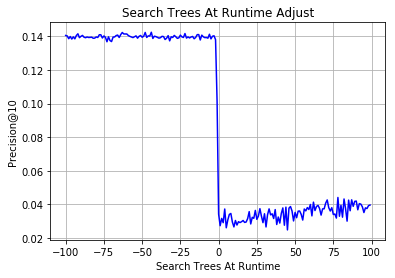

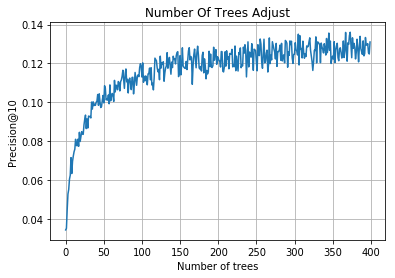

In [61]:
# Plotten der einzelnen Parameter-Precision-Werte für den BPR-Algorithmus

fig, sk = plt.subplots()
sk.plot(x6, SK_AN_ALS, 'b')

sk.set(xlabel='Search Trees At Runtime', ylabel='Precision@10', title='Search Trees At Runtime Adjust')
sk.grid()

plt.show()

fig, nt = plt.subplots()
nt.plot(x5, NT_AN_ALS)

nt.set(xlabel='Number of trees', ylabel='Precision@10', title='Number Of Trees Adjust')
nt.grid()

plt.show()

In [62]:
# Precision NMSLib-Standard

NMSL_ALS = implicit.approximate_als.NMSLibAlternatingLeastSquares()
NMSL_ALS.fit(ProductTrain)
NMSL_AN_ALS = precision_at_k(NMSL_ALS, ProductTrain.T.tocsr(), ProductTest.T.tocsr(), K=5, num_threads=4)
NMSL_AN_ALS

100%|██████████| 15.0/15 [00:01<00:00, 12.91it/s]
100%|██████████| 4338/4338 [00:00<00:00, 5336.93it/s]


0.1691919191919192

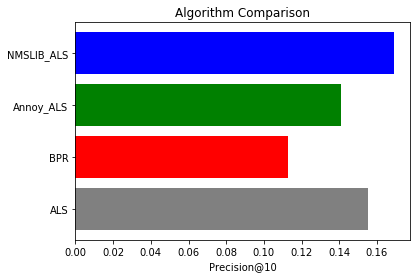

In [63]:
# Vergleich der optimierten Algorithmen

Algorithm = ('ALS', 'BPR', 'Annoy_ALS', 'NMSLIB_ALS')
y_pos = np.arange(len(Algorithm))
Precision = [P_ALS_OPT , P_BPR_OPT, P_AN_ALS_OPT, NMSL_AN_ALS]
 
#plt.barh(y_pos, Precision, align='center', alpha = 1)
plt.barh(y_pos, Precision, align='center', color=['grey', 'red', 'green', 'blue'])
#plt.bar(y_pos, height, color=['black', 'red', 'green', 'blue', 'cyan'])
plt.yticks(y_pos, Algorithm)
plt.xlabel('Precision@10')
plt.title('Algorithm Comparison')
 
plt.show()